In [73]:
import sys
sys.path.append('../../PI_GP_regressor') 

from main_class import PhysicsInformedGP_regressor
from kernels.kernel_heat_equation import gram_Matrix_jax,k_ff_jax, k_fu_jax, k_uf_jax, k_uu_jax
import numpy as np
import jax 



 /Users/tobileitgeb/Code/Code_bac/final_examples/heat_equation/../../PI_GP_regressor/main_class.py:914: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 /Users/tobileitgeb/Code/Code_bac/final_examples/heat_equation/../../PI_GP_regressor/main_class.py:926: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 /Users/tobileitgeb/Code/Code_bac/final_examples/heat_equation/../../PI_GP_regressor/main_class.py:1003: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 /Users/tobileitgeb/Code/Code_bac/final_examples/heat_equation/../../PI_GP_regressor/main_class.py:1015: UserWarning:The balance properties of Sobol' points require n to be a power of 2.


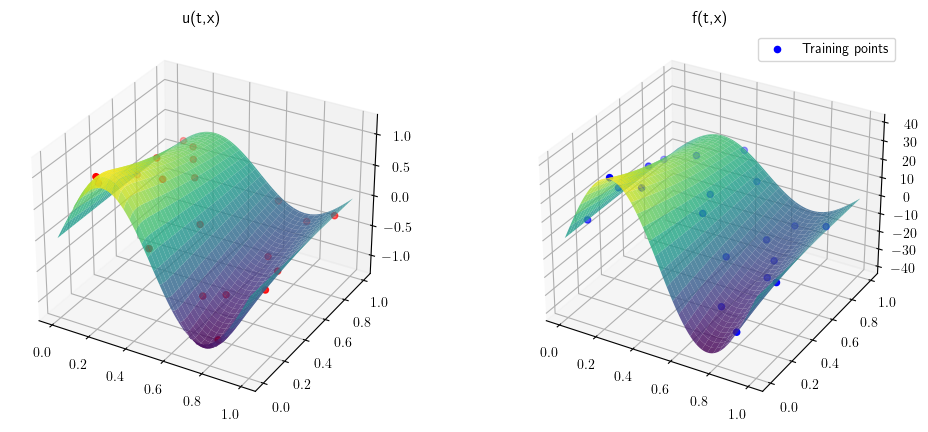

In [75]:
# first we put the kernel parts into a list
kernel_list = [gram_Matrix_jax, k_uu_jax, k_uf_jax, k_fu_jax, k_ff_jax]
#then we define the parameters for the kernel
hyperparameters = ["l_x", "sigma_f","l_t", "alpha"]
#now we can define our model. The model needs the kernel list and the hyperparameters, aswell as the timedependence
model_heat_equation = PhysicsInformedGP_regressor(kernel_list,timedependence=True, params=hyperparameters,Dimensions=2)
model_heat_equation.set_name_kernel("Wave_equation")
#now we create the training data and a validation set
n_training_points = 20
noise = [1e-8,1e-8]
model_heat_equation.set_training_data("heat_data_paper.csv",n_training_points, noise,[5,12])

n_validation_points = 1000  #for calculating the MSE
model_heat_equation.set_validation_data(n_validation_points)
model_heat_equation.plot_raw_data(True,False)

Now we can train the model. We can choose different methods for the training.   
  -CG: conjugate gradient --- fast but often not very accurate    
  -TNC: truncated Newton --- slower but more accurate     
  -L-BFGS-B: limited memory BFGS --- fast and accurate (not always for some reason)   

generally TNC is the best choice

In [76]:
#for the training we first need to define the initial parameters for the restarts
model_heat_equation.jitter = 1e-6
def get_initial_values():
    """returns the initial values for the hyperparameters
    for the length scales we initialize them randomly as log(l) ~ U(-1.3,1)
    """
    rng = np.random.default_rng()
    theta_initial = np.zeros((4))
    theta_initial[0] = np.exp(rng.uniform(-1.3, 0.3, 1))  #lx
    theta_initial[1] = rng.uniform(0, 1, 1)               #sigma_f
    theta_initial[2] = np.exp(rng.uniform(-1.3, 0.3, 1))  #lt
    theta_initial[3] = rng.uniform(0, 3, 1)               #c
    return theta_initial

n_restarts = 100; n_threads = -1
opt_params_dict = {'theta_initial': get_initial_values,   #needed for all optimization methods
                    'bounds': ((1e-2, None), (1e-5, None), (1e-3, None),(1e-2, None)), #needed for TNC and L-BFGS-B
                    'gtol': 1e-6}
model_heat_equation.train("TNC",n_restarts, n_threads,opt_params_dict)

100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


     fun: 4.383577346801758
     jac: array([ -8.5859375,  -2.1914062,  -3.578125 , -37.660156 ], dtype=float32)
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 99
     nit: 12
  status: 2
 success: True
       x: array([0.32702307, 1.22095426, 0.73154797, 0.8015203 ])


In [72]:
model_heat_equation.log_marginal_likelohood([0.18805983, 2.9, 0.73973298, 0.69992222])

Array(567.63367, dtype=float32)

In [13]:
K = gram_Matrix_jax(model_heat_equation.X,model_heat_equation.Y,model_heat_equation.get_params())
L = np.linalg.cholesky(K + 1e-6*np.eye(K.shape[0]))
#model_heat_equation.set_params([0.35847645, 2.38209643, 1.16341702, 0.99984387])

In [78]:
#model_heat_equation.set_params([0.38805983, 0.1, 1.23973298, 0.99992222])
model_heat_equation.set_params([0.32702307, 1.22095426, 0.73154797, 0.8015203 ])
model_heat_equation.jitter = 1e-6
n_test_points = 100
x_star, t_star = np.meshgrid(np.linspace(0, 1, n_test_points), np.linspace(0, 1, n_test_points))
X_star = np.hstack((x_star.reshape(-1, 1), t_star.reshape(-1, 1)))
model_heat_equation.predict_model(X_star)
model_heat_equation.error()
print(model_heat_equation)

-----------------------------------------------
GP with kernel: 
Training data: (20, 2)
Training targets: (40, 1)
Hyperparameters: {'l_x': 0.32702307, 'sigma_f': 1.22095426, 'l_t': 0.73154797, 'alpha': 0.8015203}
Log marginal likelihood: 4.383577346801758
Mean squared error: {'u': 0.0004218212270643562, 'f': 0.0565640814602375}
Relative l2 error: {'u': 0.0358022881489777, 'f': 0.01333953889778565}
-----------------------------------------------



Text(0, 0.5, '$t$')

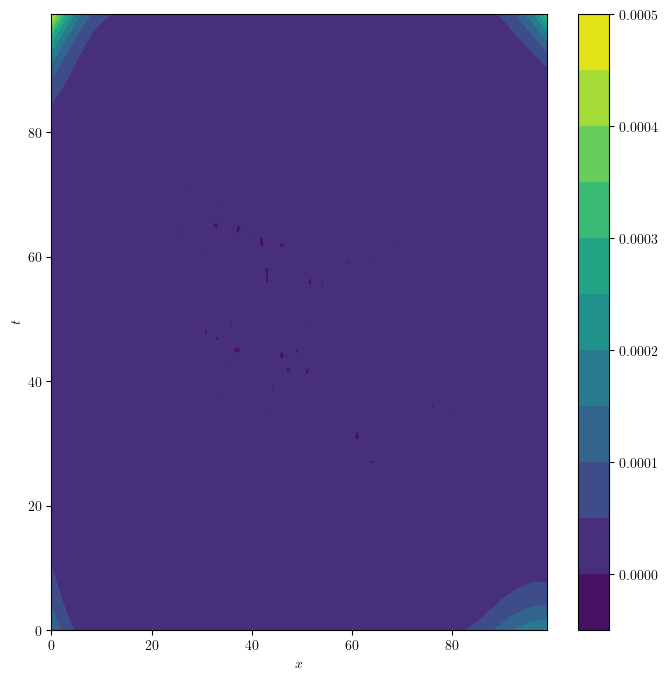

In [79]:
variance = model_heat_equation.var_u
variance = variance.reshape(n_test_points,n_test_points)
variance.shape
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.figure(figsize=(8,8))

#plt.contour(variance, cmap='viridis',levels=20)
plt.contourf(variance, cmap='viridis',levels=10)
plt.colorbar()
plt.xlabel(f"$x$")
plt.ylabel(f"$t$")


 /Users/tobileitgeb/Code/Code_bac/final_examples/heat_equation/../../PI_GP_regressor/main_class.py:1142: RuntimeWarning:invalid value encountered in sqrt
 /Users/tobileitgeb/Code/Code_bac/final_examples/heat_equation/../../PI_GP_regressor/main_class.py:1151: RuntimeWarning:invalid value encountered in sqrt


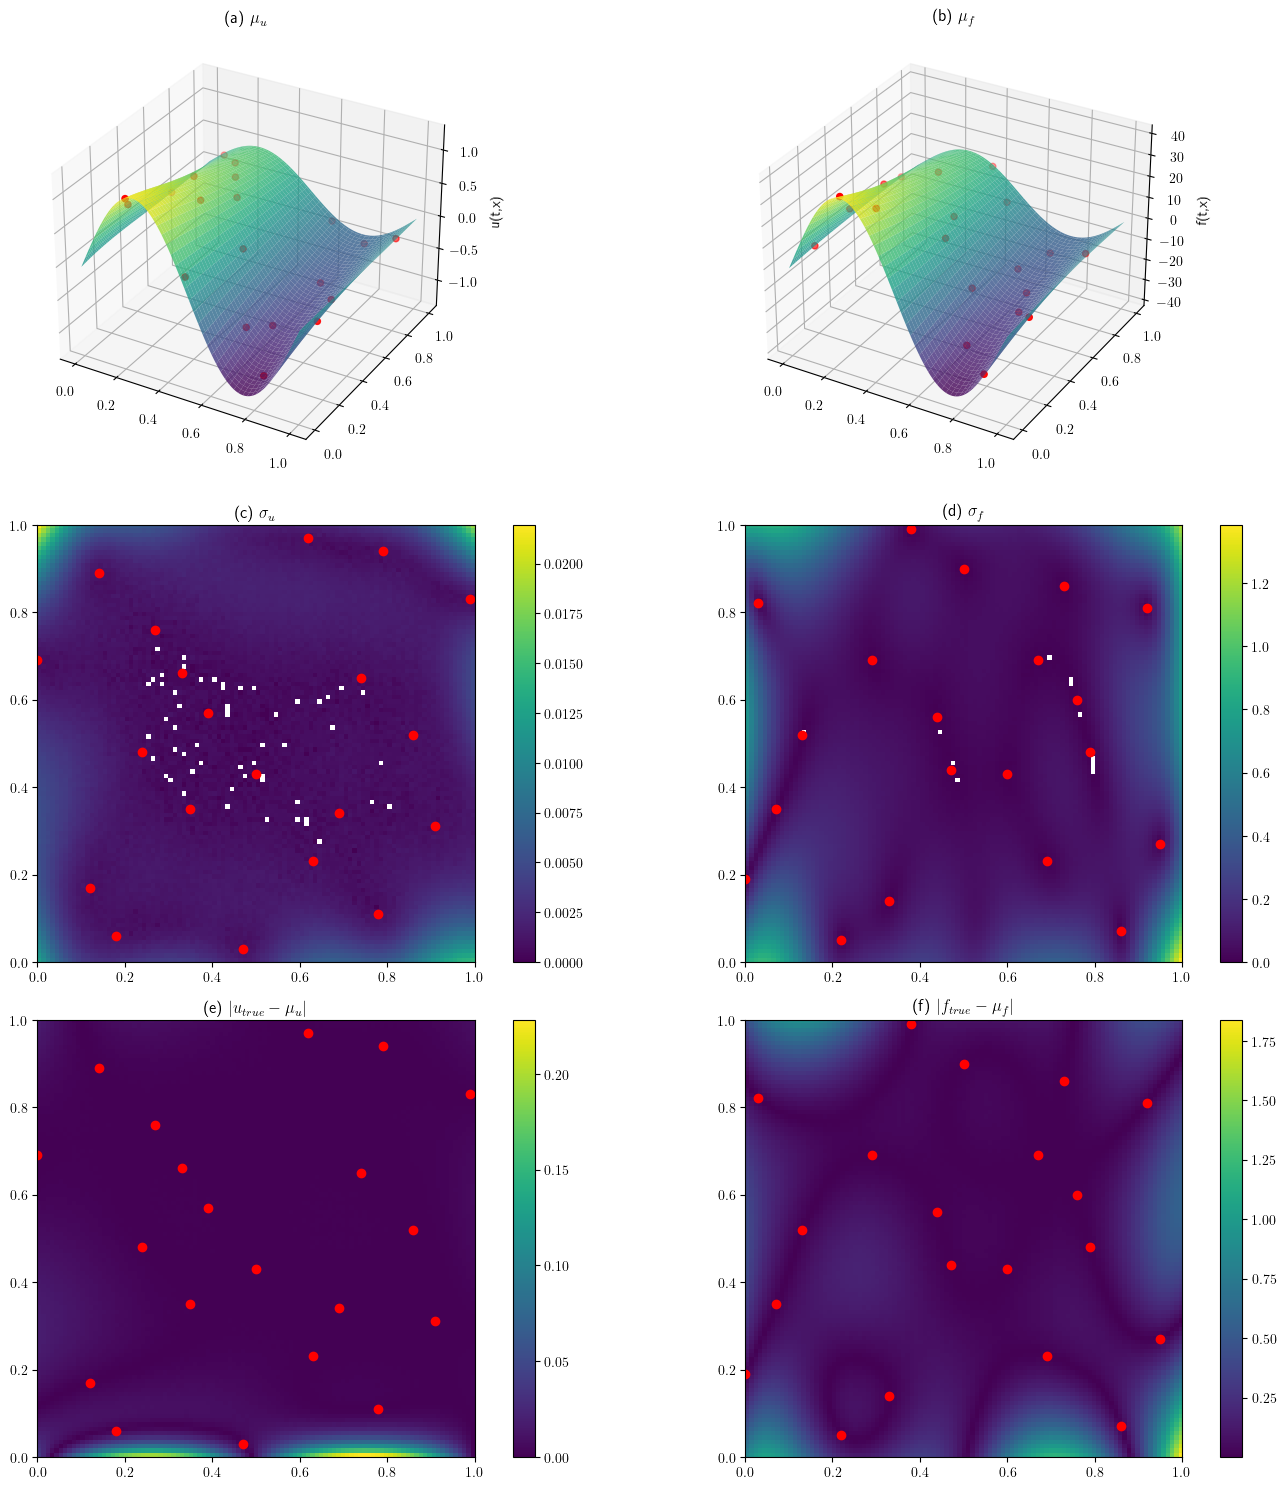

In [80]:
model_heat_equation.plot_merged_2d_plots(X_star,"merged_plots.png")

No handles with labels found to put in legend.


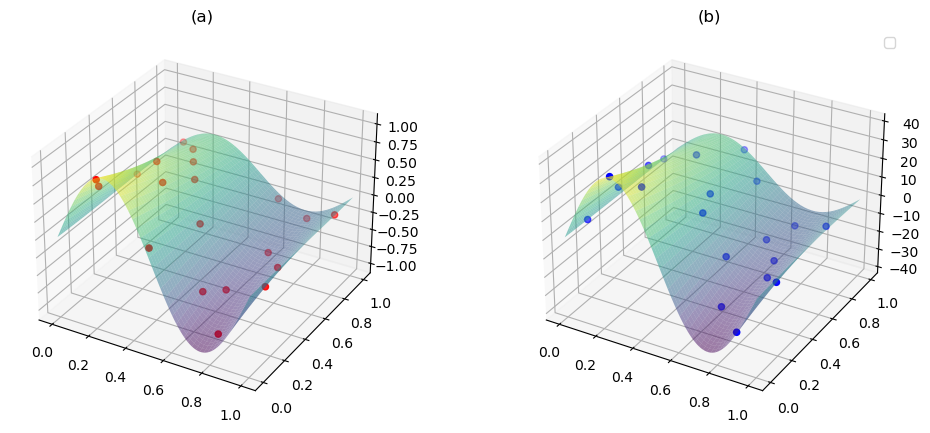

In [24]:
model_heat_equation.plot_prediction(X_star, "Predictive mean $\\overline{ f_*}$","predictive_mean.png",False)

-----------------------------------------------
GP with kernel: 
Training data: (20, 2)
Training targets: (40, 1)
Hyperparameters: {'l_x': 0.22532613623021236, 'sigma_f': 0.4268430996315112, 'l_t': 0.6945216315217704, 'alpha': 1.00310112395523}
Log marginal likelihood: 11.065858840942383
Mean squared error: {'u': 2.8943748475285247e-05, 'f': 1.037439227104187}
Relative l2 error: {'u': 0.011610873332481163, 'f': 0.05712836744826516}
-----------------------------------------------



 /Users/tobileitgeb/Code/Code_bac/final_examples/heat_equation/../../PI_GP_regressor/main_class.py:647: RuntimeWarning:invalid value encountered in sqrt
 /Users/tobileitgeb/Code/Code_bac/final_examples/heat_equation/../../PI_GP_regressor/main_class.py:656: RuntimeWarning:invalid value encountered in sqrt


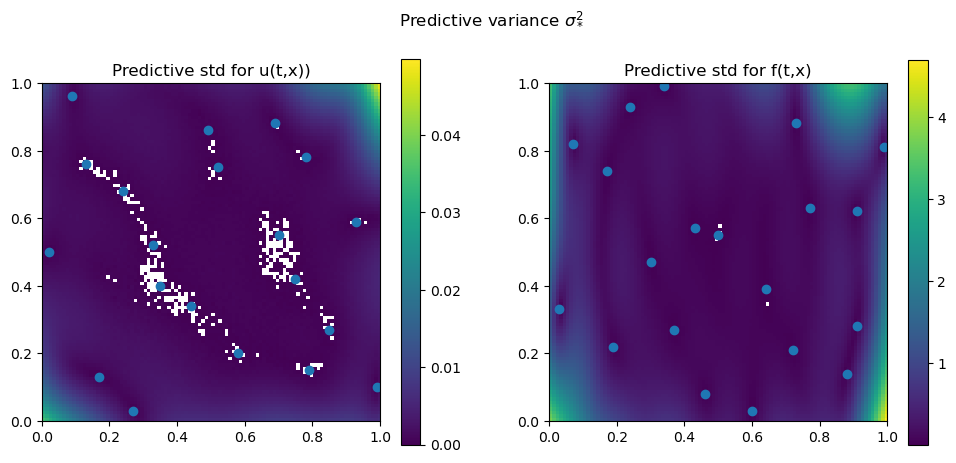

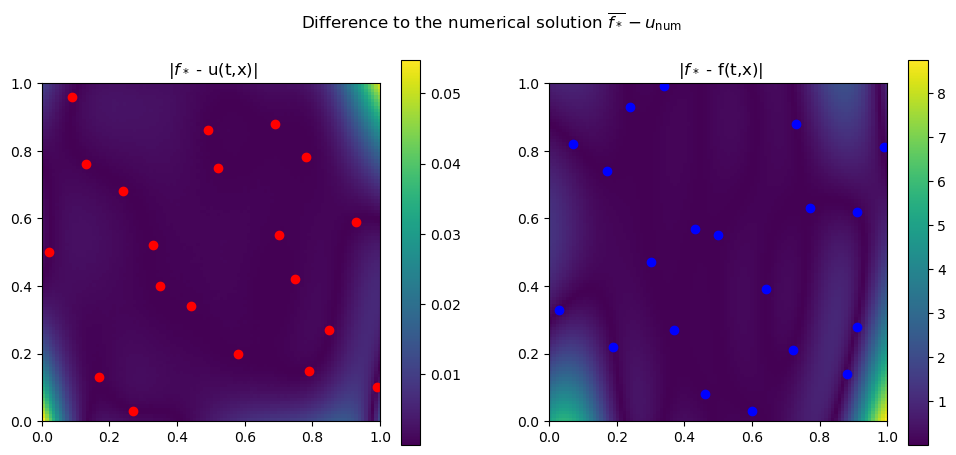

In [ ]:
model_heat_equation.error()
print(model_heat_equation)
model_heat_equation.plot_variance(X_star, "Predictive variance $\\sigma_*^2$","predictive_variance.png")
model_heat_equation.plot_difference("Difference to the numerical solution $\\overline{ f_*} - u_{\\mathrm{num}}$","difference.png")

We can now do the same with the GPy library with a non modified kernel(we just use the RBF kernel with ARD)

In [ ]:
model_heat_equation.use_GPy(X_star,"GPy_predictive_mean",False)


 /opt/homebrew/anaconda3/envs/bac/lib/python3.8/site-packages/GPy/core/__init__.py:80: FutureWarning:In the future `np.bool` will be defined as the corresponding NumPy scalar.


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
model_heat_equation.plot_difference_GPy("difference GPy ", "GPy_difference.png")
model_heat_equation.plot_variance_GPy("predictive variance GPy ", "GPy_variance.png")

AttributeError: 'PhysicsInformedGP_regressor' object has no attribute 'GPy_models'

 /Users/tobileitgeb/Code/Code_bac/final_examples/heat_equation/../../PI_GP_regressor/main_class.py:1142: RuntimeWarning:invalid value encountered in sqrt
 /Users/tobileitgeb/Code/Code_bac/final_examples/heat_equation/../../PI_GP_regressor/main_class.py:1151: RuntimeWarning:invalid value encountered in sqrt


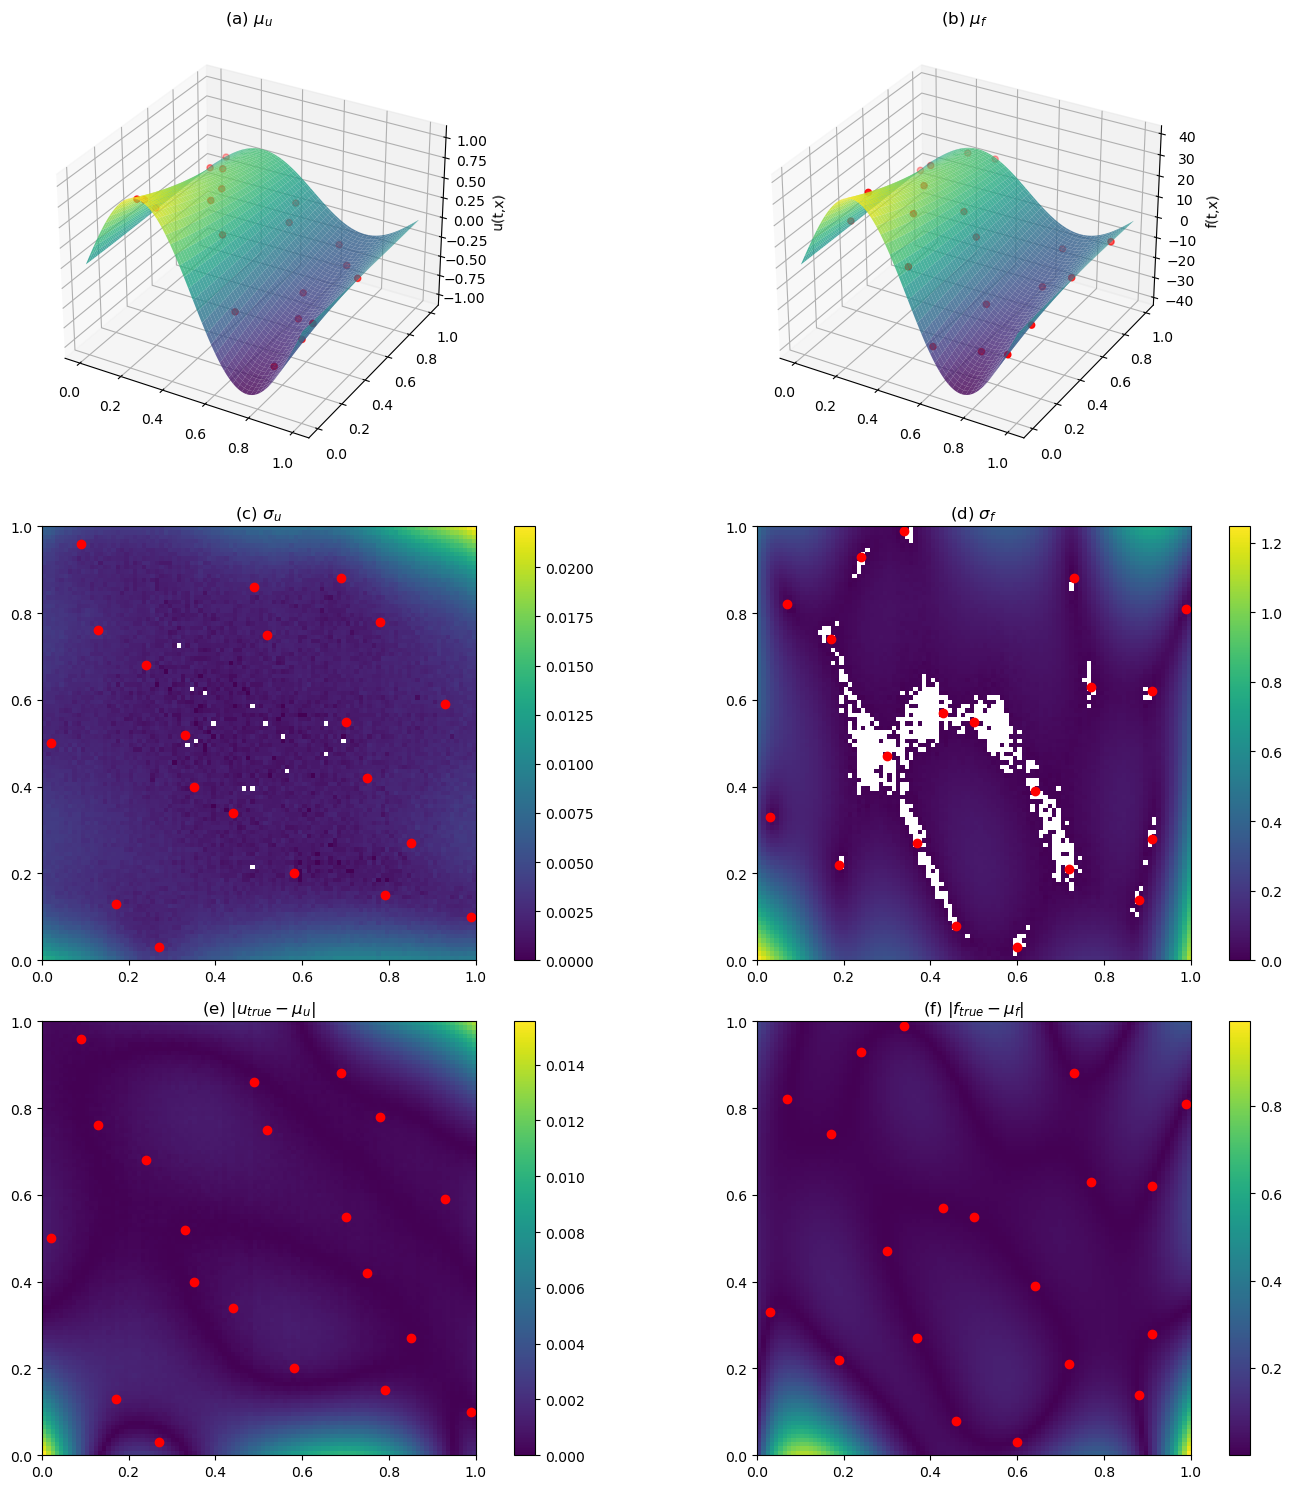